In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Add Qiskit libraries to support QFT
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
import matplotlib as mpl

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "noFT"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def fid1D_generator_from_chemical_shift(chemical_shifts, center_ppm = 4.8, H_MHz=600,  sw_ppm=14, TD=2048, R2rate=10*np.pi*2):
  '''
  fid1D_generator_from_chemical_shifts
  for making 1D FID

  inputs: chemical_shifts, center_ppm, MHz,  sw_ppm, TD, R2rate
          chemical_shifts should be one dimensional arrary.

  output: fid
  '''
  # number of residue = number of peaks
  num_residue = len(chemical_shifts)

  # generating normal distribution around the give chemical shifts
  #Hppm = np.random.normal(chemical_shifts, 0.05, num_residue)

  Hppmnorm = chemical_shifts

  Hppmnormoffseted = chemical_shifts - center_ppm

  # Now, ppm to frequency.
  Hfreq = Hppmnormoffseted*MHz

  ###### experimental-wise
  # spectral width in ppm to Hz
  sw_Hz = sw_ppm*MHz

  # spacing for measurement.
  dt = 1/sw_Hz

  # acquisition time
  # measuring real and imaginary, Thus, half.
  acq=dt*TD/2

  # time points
  time = np.linspace(0,acq,int(TD/2))

  # Relaxation
  # how much? I don't know now. But, give choice.
  # I make an API for R2rate later.
  R2 = np.random.normal(R2rate,1,num_residue)

  fid = np.empty((num_residue,int(TD/2)),dtype=complex)
  fidnoise = np.empty((num_residue,int(TD/2)),dtype=complex)

  for i in range(len(Hfreq)):
    fidind = np.exp(1.j* 2*np.pi * Hfreq[i] * time)*np.exp(-(1+0.j)*R2[i] * time)
    # adding 10% noise
    fidindnoise  = fidind + (1 + 1j)*0.1*(np.random.rand(1, int(TD/2)) - 0.5)

    fid[i,:] = fidind
    fidnoise[i,:] = fidindnoise

  # saving individual peaks
  #fidinds = sum(fid)

  # summing up over all residues
  fid = sum(fid)
  fidnoise  = sum(fidnoise)

  return fidnoise, fid

In [3]:
chemical_shifts = np.array([8,8.2,8.5,9.2,9.4,10.2]).astype('float32')
center_ppm = 4.8
MHz = 600
sw_ppm=14
TD = 2048
R2rate=10*np.pi*2

In [4]:
x_fid, y_fid = fid1D_generator_from_chemical_shift(chemical_shifts,center_ppm=center_ppm,H_MHz=MHz,sw_ppm=sw_ppm,TD=TD,R2rate=R2rate)

In [5]:
x_fid.shape,y_fid.shape
print(x_fid)

[ 6.04854396+0.04854396j -1.52415885+5.4044444j  -3.9166613 -2.28385434j
 ... -0.04480798-0.04466224j  0.01616658+0.01727718j
 -0.0654555 -0.06639964j]


Saving figure fid


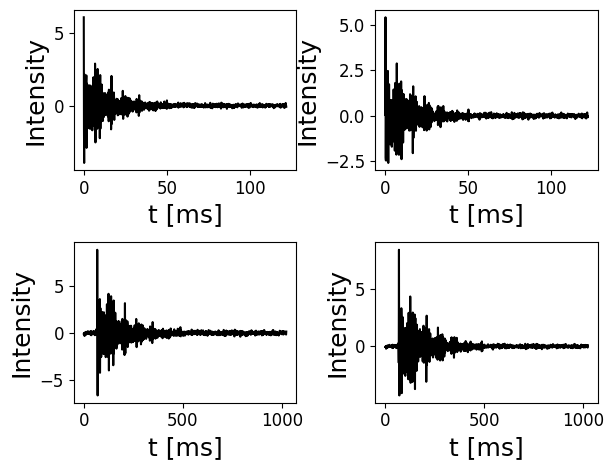

Saving figure oversampling_spec


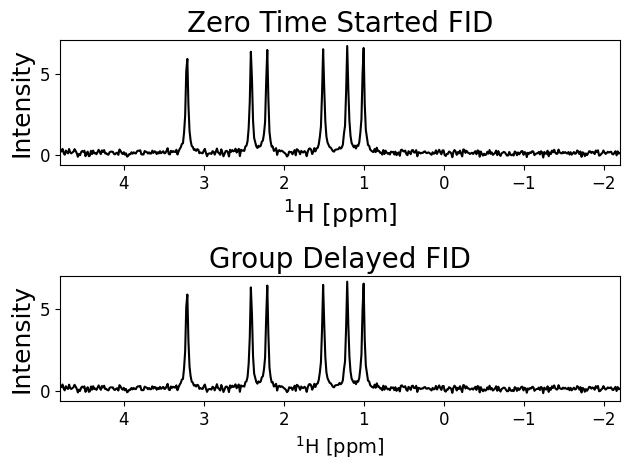

In [6]:
import nmrglue as ng
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator  # Import from qiskit_aer

# Define QFT-based processing function with support for inverse transform
def qft_transform(data, inverse=False):
    n = int(np.log2(len(data)))  # Ensure length is a power of 2 for QFT
    if 2 ** n != len(data):
        raise ValueError("Data length must be a power of 2 for QFT")

    #노름
    data = data / np.linalg.norm(data)

    # Create a QFT circuit
    qft_circuit = QuantumCircuit(n)
    #회로 초기화 코드 추가
    qft_circuit.initialize(data, range(n))  
    qft_circuit.append(QFT(num_qubits=n, do_swaps=True, inverse=inverse), range(n))
    qft_circuit.save_statevector() 

    # Simulate the circuit
    simulator = AerSimulator()
    transpiled_circuit = transpile(qft_circuit, simulator)
    result = simulator.run(transpiled_circuit).result()
    statevector = result.get_statevector() 
    
    # Convert Statevector to NumPy array
    statevector = np.array(statevector)
    scaled_statevector = statevector * np.sqrt(2**n)

    return scaled_statevector


# Parameter settings
Hppmmin = center_ppm - sw_ppm / 2
Hppmmax = center_ppm + sw_ppm / 2
x = np.linspace(Hppmmin, Hppmmax, int(TD / 2))

# Step 1: QFT Transformation (Replaces nmrglue.proc_base.fft(x_fid))
spec = qft_transform(x_fid,inverse=True)
spec_real = spec.real
spec_imag = spec.imag
#x_fid는 자유감쇠신호 -> QFT를 적용해서 주파수영역의 신호를 얻음
#역QFT를 적용해서 다시 시간영역의 신호를 얻음
#잘못된 그래프에는 위상변환이 적용된 fid가 나타나야함


# Creating group delay
p0 = 0
p1 = -360 * 68 * np.pi / 180
phasecor = np.exp(1j * (p0 + p1 * np.linspace(0, int(TD / 2), int(TD / 2))))
spec_syn_group_delay = spec * phasecor

# Step 2: Inverse QFT (Replaces nmrglue.proc_base.ifft(spec_syn_group_delay))
fid_group_delayed = qft_transform(spec_syn_group_delay,inverse=False)
fid_group_delayed_real = fid_group_delayed.real
fid_group_delayed_imag = fid_group_delayed.imag



# Plotting FID components
dt = 1 / (sw_ppm * MHz)
aqtime = dt * TD / 2
time = np.linspace(0, aqtime * 1000, int(TD / 2))


plt.subplot(2, 2, 1)
plt.plot(time, x_fid.real, 'k')
plt.xlabel(r't [ms]', fontsize=18)
plt.ylabel(r'Intensity', fontsize=18)

plt.subplot(2, 2, 2)
plt.plot(time, x_fid.imag, 'k')
plt.xlabel(r't [ms]', fontsize=18)
plt.ylabel(r'Intensity', fontsize=18)

plt.subplot(2, 2, 3)
plt.plot(fid_group_delayed_real, 'k')
plt.xlabel(r't [ms]', fontsize=18)
plt.ylabel(r'Intensity', fontsize=18)

plt.subplot(2, 2, 4)
plt.plot(fid_group_delayed_imag, 'k')
plt.xlabel(r't [ms]', fontsize=18)
plt.ylabel(r'Intensity', fontsize=18)
save_fig("fid")
plt.show()


# Final QFT back to spectrum
spec_group_delayed = qft_transform(fid_group_delayed,inverse=True)
p0 = 0
p1 = 360 * 68 * np.pi / 180
phasecor = np.exp(1j * (p0 + p1 * np.linspace(0, int(TD / 2), int(TD / 2))))
spec_group_delayed = phasecor * spec_group_delayed


# Plotting final spectra
plt.subplot(2, 1, 1)
plt.plot(x, spec_real, 'k')
plt.xlim(center_ppm, Hppmmin)
plt.xlabel(r'$^1$H [ppm]', fontsize=18)
plt.ylabel(r'Intensity', fontsize=18)
plt.title('Zero Time Started FID', fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(x, spec_group_delayed.real, 'k')
plt.xlim(center_ppm, Hppmmin)
plt.xlabel(r'$^1$H [ppm]')
plt.ylabel(r'Intensity', fontsize=18)
plt.title('Group Delayed FID', fontsize=20)

save_fig("oversampling_spec")
plt.show()

#x_fid -(QFT적용)-> spec -(그룹딜레이 적용)-> spec_syn_group_delay -(역QFT적용)->fid_group_delayed -(QFT)->spec_group_delayed



In [7]:
def processing(data):
  pdata = data

  # first point scaling
  pdata[0] = pdata[0]*0.5

  pdata = ng.proc_base.sp(pdata,off=0.5,end=0.95,pow=2.0)
  pdata = ng.proc_base.zf(pdata,len(pdata))
  pdata = ng.proc_base.fft(pdata)
  pdata = ng.proc_base.di(pdata)

  return pdata

In [8]:
x_specp = processing(x_fid)
y_specp = processing(y_fid)

x_specp.shape, y_specp.shape

((2048,), (2048,))

Saving figure six_ppm_spectrum


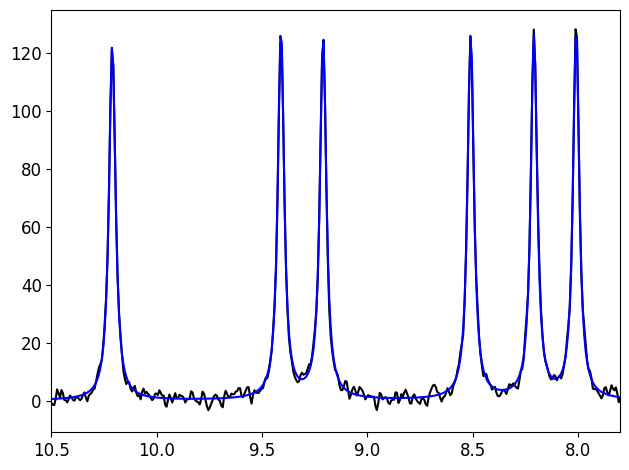

array([ 8. ,  8.2,  8.5,  9.2,  9.4, 10.2], dtype=float32)

In [9]:
x = np.linspace(Hppmmin,Hppmmax,2048)

plt.plot(x, x_specp, 'k')
plt.plot(x, y_specp, 'b')

plt.xlim(10.5,7.8)
save_fig("six_ppm_spectrum")
plt.show()

chemical_shifts

In [75]:
num_fid = 1024

TD = 2048

x_fids = np.empty((num_fid,int(TD/2)),dtype=complex)
y_fids = np.empty((num_fid,int(TD/2)),dtype=complex)

num_residue = 100
Hppms = np.empty((num_fid, num_residue))

x_specs = np.empty((num_fid,int(TD)))
y_specs = np.empty((num_fid,int(TD)))
#specinds = np.empty((num_fid, num_residue, int(TD)))

for a in range(num_fid):
  np.random.seed(a)
  Hppm = np.random.normal(8.5,1,num_residue)
  Hppm = np.round(Hppm,2)

  x_fid, y_fid = fid1D_generator_from_chemical_shift(Hppm,TD=TD)
  x_spec = processing(x_fid)
  y_spec = processing(y_fid)

  # the perfect peaks
  #specpinds = np.empty((num_residue,TD))
  #for i in range(num_residue):
  #  specpind = processing(fidinds[i,:])
  #  specpinds[i,:] = specpind

  # features need to be normalized but label doesn't
  # specpins will be the right one

  x_fid = x_fid/np.max(abs(x_fid))
  y_fid = y_fid/np.max(abs(y_fid))
  x_spec = x_spec/np.max(abs(x_spec))
  y_spec = y_spec/np.max(abs(y_spec))
  #specpinds = specpinds/np.max(abs(specpinds))

  x_fids[a] = x_fid
  y_fids[a] = y_fid
  x_specs[a] = x_spec
  y_specs[a] = y_spec
  Hppms[a] = Hppm
  
  #실행시간 대충 10초 걸림

In [76]:
x_fids.shape,Hppms.shape, x_specs.shape, y_specs.shape

((1024, 1024), (1024, 100), (1024, 2048), (1024, 2048))

Saving figure spec_vs_pefectspec


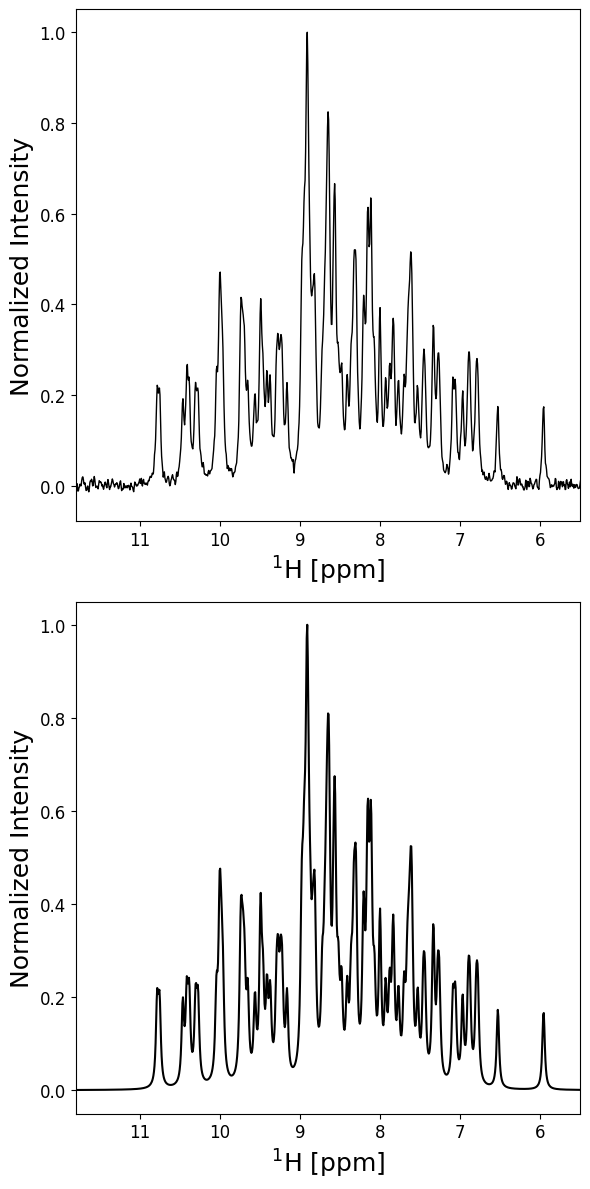

In [77]:
x = np.linspace(Hppmmin,Hppmmax,2048)

plt.figure(figsize=(6,12))

plt.subplot(2,1,1)
plt.plot(x, x_specs[0],'k',linewidth=1)
plt.xlim(Hppmmax,5.5)
plt.xlabel(r'$^1$H [ppm]',fontsize=18)
plt.ylabel("Normalized Intensity",fontsize=18)

plt.subplot(2,1,2)
plt.plot(x,y_specs[0],'k')
plt.xlim(Hppmmax,5.5)
plt.xlabel(r'$^1$H [ppm]',fontsize=18)
plt.ylabel("Normalized Intensity",fontsize=18)
save_fig("spec_vs_pefectspec")
plt.show()

## QNN 적용부분

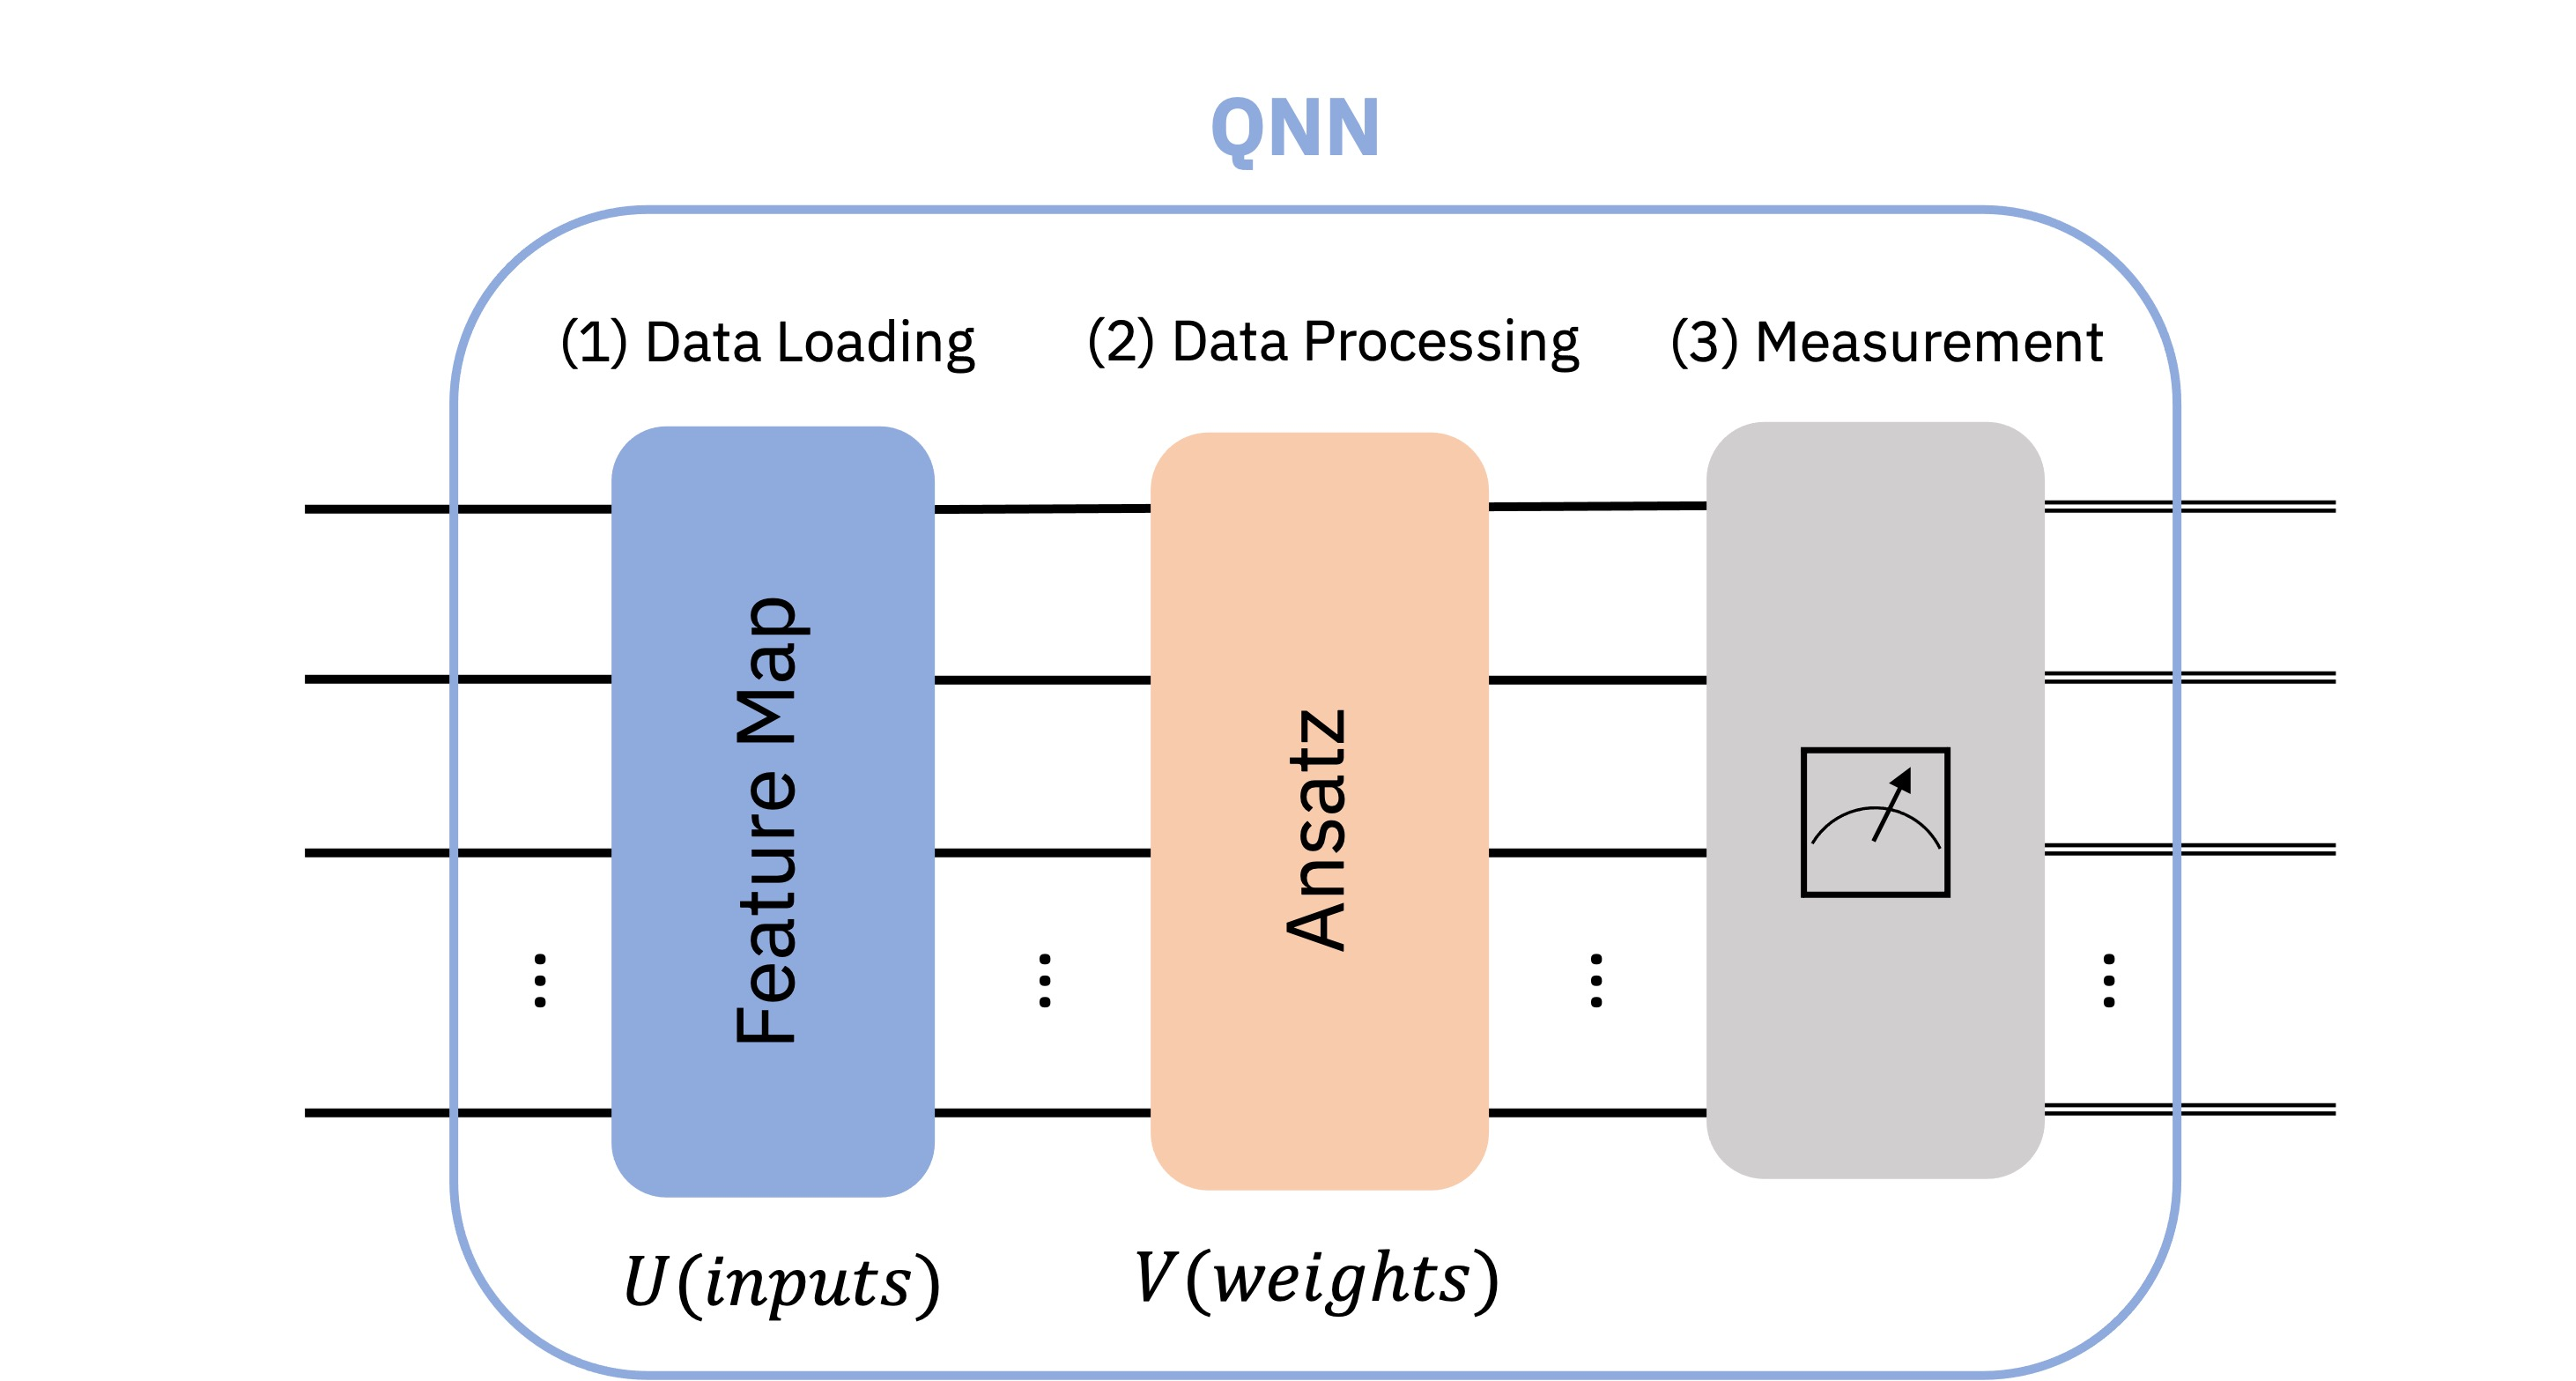
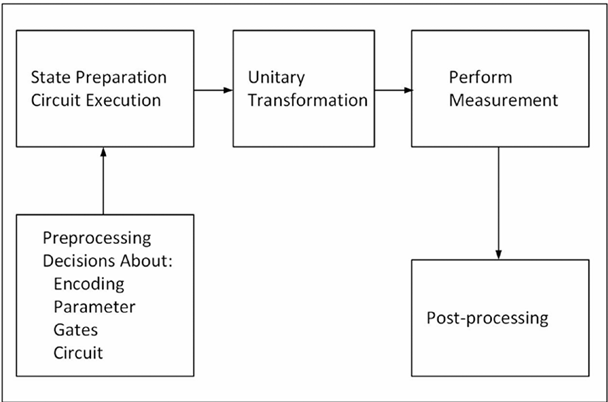

In [78]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import StatePreparation
from qiskit.exceptions import QiskitError


In [98]:
x_fid_real_imag = np.empty((1024,2048))
x_fid_real_imag[:,0::2] = x_fids.real
x_fid_real_imag[:,1::2] = x_fids.imag
spec_fft = np.fft.fft(x_fid_real_imag[:,0::2]).real

In [15]:
def dft_matrix(N):
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return M

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1024, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1024, 8)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 512, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        65,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,720 (256.72 KB)

 Trainable params: 65,720 (256.72 KB)

 Non-trainable params: 0 (0.00 B)

     ┌──────────┐ ░ ┌──────────┐                                    ░ »
q_0: ┤ Ry(x[0]) ├─░─┤ Ry(θ[0]) ├──■─────────────────────────────────░─»
     ├──────────┤ ░ ├──────────┤┌─┴─┐                               ░ »
q_1: ┤ Ry(x[1]) ├─░─┤ Ry(θ[1]) ├┤ X ├──■────────────────────────────░─»
     ├──────────┤ ░ ├──────────┤└───┘┌─┴─┐                          ░ »
q_2: ┤ Ry(x[2]) ├─░─┤ Ry(θ[2]) ├─────┤ X ├──■───────────────────────░─»
     ├──────────┤ ░ ├──────────┤     └───┘┌─┴─┐                     ░ »
q_3: ┤ Ry(x[3]) ├─░─┤ Ry(θ[3]) ├──────────┤ X ├──■──────────────────░─»
     ├──────────┤ ░ ├──────────┤          └───┘┌─┴─┐                ░ »
q_4: ┤ Ry(x[4]) ├─░─┤ Ry(θ[4]) ├───────────────┤ X ├──■─────────────░─»
     ├──────────┤ ░ ├──────────┤               └───┘┌─┴─┐           ░ »
q_5: ┤ Ry(x[5]) ├─░─┤ Ry(θ[5]) ├────────────────────┤ X ├──■────────░─»
     ├──────────┤ ░ ├──────────┤                    └───┘┌─┴─┐      ░ »
q_6: ┤ Ry(x[6]) ├─░─┤ Ry(θ[6]) ├─────────────────────────┤ X ├──

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22332\1045777317.py:50: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


Sample 0, Loss = 0.7919, Accuracy (MAE) = 0.7919
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1

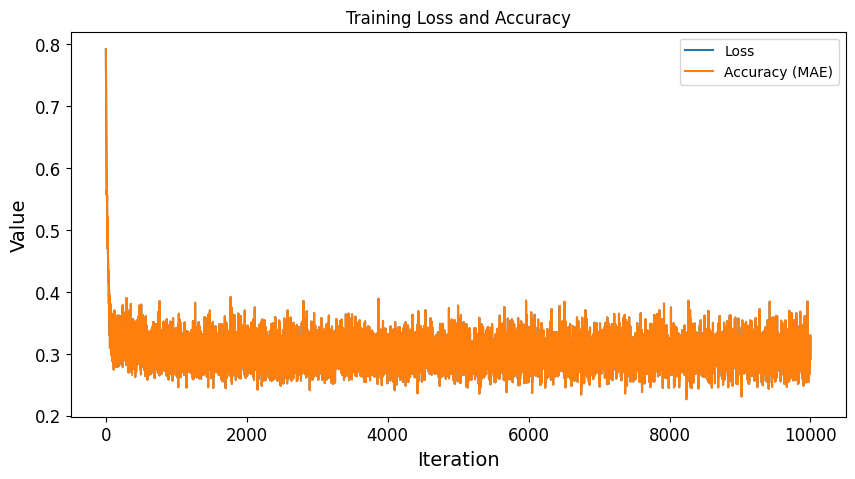

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [24]:
#########################################
# 각 인코딩
########################################

# 데이터 준비
X_data = x_fid_real_imag[:, 0::2]  # shape=(1024, 1024)  (Real part)
y_data = spec_fft                  # shape=(1024, 1024)

# 2. CNN (텐서플로)로 1024차원 -> 8차원 축소
tf.keras.backend.clear_session()

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Reshape((1024, 1), input_shape=(1024,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='linear')
])
model_cnn.summary()

##############################################################################
# 3) Qiskit 회로 (8큐빗 + measure_all) -> (batch, 256) 가능
##############################################################################
num_qubits = 8
data_params = ParameterVector("x", 8)
weight_params = ParameterVector("θ", 2*num_qubits)

def create_quantum_network():
    qc = QuantumCircuit(num_qubits)
    # Angle Encoding
    for i in range(num_qubits):
        qc.ry(data_params[i], i)
    qc.barrier()
    # ansatz
    for i in range(num_qubits):
        qc.ry(weight_params[i], i)
    for i in range(num_qubits-1):
        qc.cx(i, i+1)
    qc.barrier()
    for i in range(num_qubits):
        qc.ry(weight_params[num_qubits + i], i)
    for i in range(num_qubits-1):
        qc.cx(i, i+1)
    print(qc)
    return qc

qc_template = create_quantum_network()

qnn = SamplerQNN(
    circuit=qc_template,
    input_params=data_params,
    weight_params=weight_params,
    sparse=False  # dense output
)

# TorchConnector
qnn_torch = TorchConnector(qnn)

##############################################################################
# 4) PyTorch 모델 (CNN -> QNN(256차원) -> 디코더(256->1024, DFT 초기화))
##############################################################################
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # QNN ansatz 파라미터(θ) 등록 (학습 가능)
        self.theta = nn.Parameter(torch.randn(2*num_qubits))
        
        # 5-1) 첫 번째 디코더 (256->1024), 기본 랜덤 초기화
        self.decoder1 = nn.Sequential(
            nn.Linear(256, 1024),  # 입력 크기를 8로 맞춤
            nn.ReLU()
        )
        
        # 5-2) 두 번째 디코더 (1024->1024), DFT 행렬로 초기화
        self.decoder2 = nn.Linear(1024, 1024)
        
        # ----- DFT 초기화 -----
        W_dft = dft_matrix(1024)      # (1024, 1024), 복소
        W_real = W_dft.real        # 실수부만
        # PyTorch weight는 (out_features, in_features) = (1024,1024)
        # dft_matrix가 (1024,1024)이므로 shape 동일, transpose 불필요
        W_torch = torch.from_numpy(W_real).float()
        bias_zeros = torch.zeros(1024)
        
        with torch.no_grad():
            self.decoder2.weight.copy_(W_torch)
            self.decoder2.bias.copy_(bias_zeros)
        
    def forward(self, x_single):
        """
        x_single: shape=(1,1024) - 1개 샘플 FID
        최종 출력: shape=(1,1024)
        """
        # (1) CNN (TensorFlow) -> (1,8)
        x_np = x_single.detach().cpu().numpy()    # (1,1024)
        x_reduced = model_cnn.predict(x_np)       # (1,8)
        
        # (2) angle encode (간단히 arctan)
        x_enc = np.arctan(x_reduced[0])           # (8,)
        x_enc = np.expand_dims(x_enc, axis=0)     # (1,8)
        
        # (3) QNN => measure_all => (1,256)
        inputs_torch = torch.from_numpy(x_enc).float()
        qnn_out = qnn_torch(inputs_torch)         # (1,256)
        
        # (4) decoder1(256->1024) -> decoder2(1024->1024, DFT init)
        inter = self.decoder1(qnn_out)            # (1,1024)
        pred_spectrum = self.decoder2(inter)      # (1,1024)
        return pred_spectrum

##############################################################################
# 5) 학습 루프
##############################################################################
model_torch = HybridModel()
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)
criterion = nn.L1Loss()

loss_values = []
accuracy_values = []

model_torch.train()
for i in range(10000):
    x_single = torch.tensor(X_data[i], dtype=torch.float32).unsqueeze(0)  # (1,1024)
    y_single = torch.tensor(y_data[i], dtype=torch.float32).unsqueeze(0)  # (1,1024)
    
    optimizer.zero_grad()
    pred = model_torch(x_single)        # (1,1024)
    loss = criterion(pred, y_single)    # 스펙트럼 전체(1024)에 대한 MSE
    loss.backward()
    optimizer.step()
    
    # 손실값 저장
    loss_values.append(loss.item())
    
    
    if i % 100 == 0:
        print(f"Sample {i}, Loss = {loss.item():.4f}")

# 손실 및 정확도 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.plot(accuracy_values, label='Accuracy (MAE)')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Training Loss')
plt.legend()
plt.show()
# 7. 첫 번째 샘플 예측 vs 실제 비교
model_torch.eval()
with torch.no_grad():
    first_x = torch.tensor(X_data[0], dtype=torch.float32).unsqueeze(0)  # (1,1024)
    pred_spectrum = model_torch(first_x)                                 # (1,1024)
    pred_spectrum = pred_spectrum.detach().numpy()[0]  # detach() 추가
    true_spectrum = y_data[0]

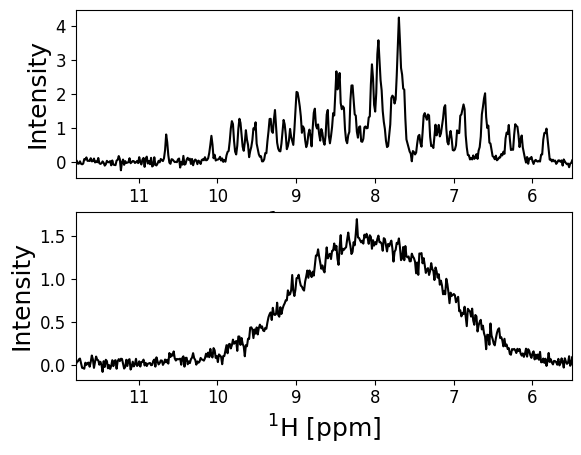

In [25]:
#각인코딩 결과

xh = np.linspace(Hppmmax,Hppmmin,1024)
plt.subplot(2,1,1)
plt.plot(xh,spec_fft[0].real,'k')
plt.xlim(Hppmmax,5.5)
plt.xlabel(r'$^1$H [ppm]',fontsize=18)
plt.ylabel("Intensity",fontsize=18)

plt.subplot(2,1,2)
plt.plot(xh, pred_spectrum,'k')
plt.xlim(Hppmmax,5.5)
plt.xlabel(r'$^1$H [ppm]',fontsize=18)
plt.ylabel("Intensity",fontsize=18)


plt.show()

In [ ]:
from qiskit.primitives import Sampler
#########################################
# 진폭 인코딩으로 구현
#########################################

# 데이터 준비
X_data = x_fid_real_imag[:, 0::2]  # shape=(10000, 1024)  (Real part)
y_data = spec_fft                  # shape=(10000, 1024)

# QNN 정의
class AmplitudeEncodingQNN(nn.Module):
    def __init__(self, num_qubits, weight_params):
        super().__init__()
        self.num_qubits = num_qubits
        self.weight_params = nn.Parameter(torch.tensor(weight_params, dtype=torch.float32))

    def forward(self, data):
        simulator = Sampler()
        outputs = []

        for sample in data:
            # 진폭 인코딩된 데이터를 초기화
            qc = QuantumCircuit(self.num_qubits)
            state_prep = StatePreparation(sample,normalize=True)
            qc.append(state_prep, range(self.num_qubits))

            # NumPy 배열로 RY 게이트에 전달
            weights_np = self.weight_params.detach().cpu().numpy()
            for i in range(self.num_qubits):
                qc.ry(weights_np[i], i)
            for i in range(self.num_qubits - 1):
                qc.cx(i, i + 1)
            for i in range(self.num_qubits):
                qc.ry(weights_np[self.num_qubits + i], i)
            for i in range(self.num_qubits - 1):
                qc.cx(i, i + 1)
            qc.measure_all()

            # 측정 및 확률 계산
            job = simulator.run(qc)
            counts = job.result().get_counts()

            probs = np.zeros(2 ** self.num_qubits)
            for key, count in counts.items():
                probs[int(key, 2)] = count / 1024

            outputs.append(probs)

        return torch.tensor(outputs, dtype=torch.float32)

# PyTorch 모델 정의
class HybridModel(nn.Module):
    def __init__(self, num_qubits, weight_params):
        super().__init__()
        self.qnn = AmplitudeEncodingQNN(num_qubits, weight_params)
        self.decoder = nn.Sequential(
            nn.Linear(2 ** num_qubits, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def forward(self, x):
        # PyTorch 텐서를 NumPy 배열로 변환
        x_np = x.detach().cpu().numpy()
        
        # QNN 호출 (NumPy 배열을 사용)
        qnn_output = self.qnn(x_np)
        
        # 디코더로 예측 결과 변환
        decoded = self.decoder(qnn_output)
        return decoded

# 데이터 준비
num_qubits = 10
X_data = np.random.rand(1024, 1024)
y_data = np.random.rand(1024, 1024)
weight_params = np.random.rand(2 * num_qubits)

# 학습 루프
model = HybridModel(num_qubits, weight_params)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

loss_values = []
for i in range(1024):
    x_single = torch.tensor(X_data[i], dtype=torch.float32).unsqueeze(0)
    y_single = torch.tensor(y_data[i], dtype=torch.float32).unsqueeze(0)
    optimizer.zero_grad()
    pred = model(x_single)
    loss = criterion(pred, y_single)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    if i % 100 == 0:
        print(f"Sample {i}, Loss = {loss.item():.4f}")

# 손실 그래프 출력
plt.plot(loss_values)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 6. 첫 번째 샘플 예측 vs 실제 비교
model.eval()
with torch.no_grad():
    first_x = torch.tensor(X_data[0], dtype=torch.float32).unsqueeze(0)  # (1, 1024)
    pred_spectrum = model(first_x)  # (1, 1024)
    pred_spectrum = pred_spectrum.numpy()[0]
    true_spectrum = y_data[0]



c:\Users\wjdrm\anaconda3\envs\keras\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wjdrm\anaconda3\envs\keras\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wjdrm\anaconda3\envs\keras\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wjdrm\anaconda3\envs\keras\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wjdrm\anaconda3\envs\keras\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from

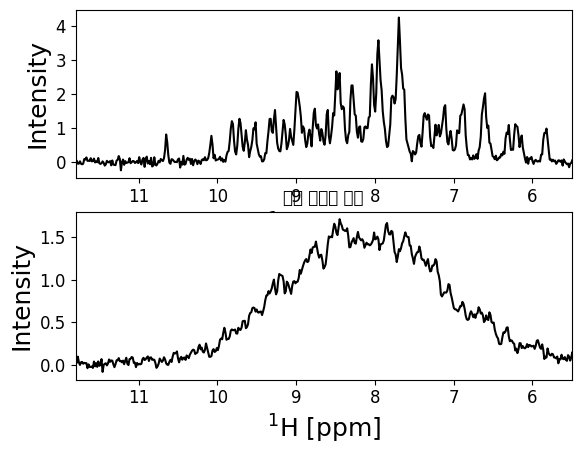

In [16]:
#진폭인코딩 결과
xh = np.linspace(Hppmmax,Hppmmin,1024)

plt.subplot(2,1,1)
plt.plot(xh,spec_fft[0].real,'k')
plt.xlim(Hppmmax,5.5)
plt.xlabel(r'$^1$H [ppm]',fontsize=18)
plt.ylabel("Intensity",fontsize=18)

plt.subplot(2,1,2)
plt.plot(xh, pred_spectrum,'k')
plt.xlim(Hppmmax,5.5)
plt.xlabel(r'$^1$H [ppm]',fontsize=18)
plt.ylabel("Intensity",fontsize=18)
plt.title('진폭 인코딩 결과')

plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22332\239609203.py:34: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


Sample 0, Loss = 0.7848
Sample 100, Loss = 0.2210
Sample 200, Loss = 0.2322
Sample 300, Loss = 0.2337
Sample 400, Loss = 0.3419
Sample 500, Loss = 0.2253
Sample 600, Loss = 0.2685
Sample 700, Loss = 0.2403
Sample 800, Loss = 0.2525
Sample 900, Loss = 0.2756
Sample 1000, Loss = 0.2157


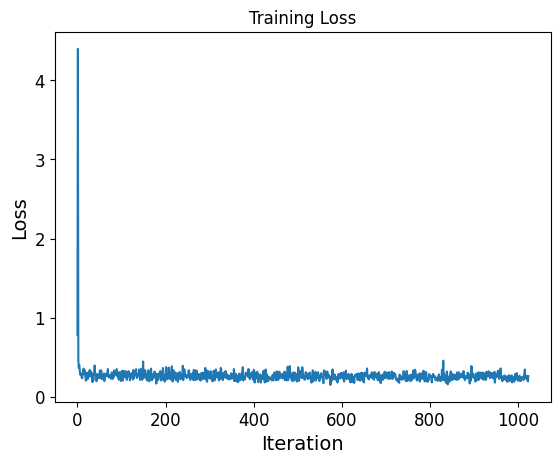

In [109]:
from qiskit.circuit.library import ZZFeatureMap,RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import EfficientSU2
from qiskit_machine_learning.gradients import ParamShiftSamplerGradient

X_data = x_fid_real_imag[:, 0::2]  # shape=(10000, 1024)  (Real part)
y_data = spec_fft                  # shape=(10000, 1024)


# FFT 가중치 계산 함수
def compute_fft_weights(size):
    weights = np.empty((size, size), dtype=complex)
    for index_k in range(size):
        for index_n in range(size):
            weights[index_n, index_k] = np.exp(-1.j * 2 * np.pi * index_k * index_n / size)
    return weights

# FFT 가중치 계산
fft_weights = compute_fft_weights(1024)
num_qubits = 8

# QNN 준비
feature_map = ZZFeatureMap(feature_dimension=num_qubits,reps=1)
ansatz = EfficientSU2(num_qubits=num_qubits, reps=5)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

input_params = feature_map.parameters
weight_params = ansatz.parameters

qnn = SamplerQNN(
    circuit=qc,
    input_params=input_params,
    weight_params=weight_params,
    sparse=False
)
qnn_torch = TorchConnector(qnn)

# PyTorch 모델 정의
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN 모델 정의 (1024 -> 8차원 축소)
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=5, padding=1),  # [batch, 8, 1024]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),               # [batch, 8, 256]
            nn.Flatten(),                              # [batch, 8 * 256 = 2048]
            nn.Linear(4088, 8),                        # [batch, 8]
            nn.ReLU()
        )
        self.qnn = qnn_torch  # QNN 연결
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),  # [batch, 512]
            nn.ReLU(),
            nn.Linear(512, 1024)  # [batch, 1024]
        )

        # FFT 가중치 초기화
        self.fft_weights_real = nn.Parameter(torch.tensor(fft_weights.real, dtype=torch.float32))
        self.fft_weights_imag = nn.Parameter(torch.tensor(fft_weights.imag, dtype=torch.float32))

    def forward(self, x):
        x_cnn = self.cnn(x.unsqueeze(1))  # CNN 적용 (입력 크기: [batch, 1, 1024])
        qnn_output = self.qnn(x_cnn)      # QNN 호출
        decoded = self.decoder(qnn_output)  # 결과 디코딩
        # FFT 가중치 적용
        fft_real = torch.matmul(decoded, self.fft_weights_real)
        fft_imag = torch.matmul(decoded, self.fft_weights_imag)
        fft_output = torch.sqrt(fft_real ** 2 + fft_imag ** 2)
        return fft_output

# 모델 초기화
model = HybridModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

loss_values = []

# 학습 루프
for epoch in range(1):  # 에폭 수 설정
    for i in range(1024):
        x_single = torch.tensor(X_data[i], dtype=torch.float32).unsqueeze(0)  # 입력 데이터
        y_single = torch.tensor(y_data[i], dtype=torch.float32).unsqueeze(0)  # 목표 출력

        optimizer.zero_grad()
        pred = model(x_single)  # 예측
        loss = criterion(pred, y_single)  # 손실 계산
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())
        if i % 100 == 0:
            print(f"Sample {i}, Loss = {loss.item():.4f}")

# 손실 그래프 출력
plt.plot(loss_values)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 예측 결과 확인
model.eval()
with torch.no_grad():
    first_x = torch.tensor(X_data[0], dtype=torch.float32).unsqueeze(0)
    pred_spectrum = model(first_x).detach().numpy()[0]
    true_spectrum = y_data[0]


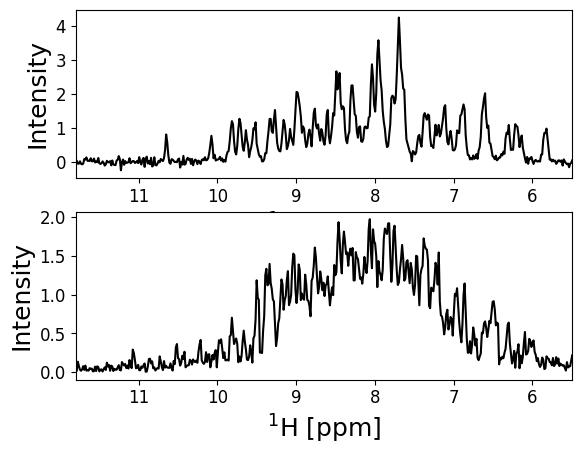

In [110]:
#각인코딩 결과

xh = np.linspace(Hppmmax,Hppmmin,1024)
plt.subplot(2,1,1)
plt.plot(xh,spec_fft[0].real,'k')
plt.xlim(Hppmmax,5.5)
plt.xlabel(r'$^1$H [ppm]',fontsize=18)
plt.ylabel("Intensity",fontsize=18)

plt.subplot(2,1,2)
plt.plot(xh, pred_spectrum,'k')
plt.xlim(Hppmmax,5.5)
plt.xlabel(r'$^1$H [ppm]',fontsize=18)
plt.ylabel("Intensity",fontsize=18)


plt.show()

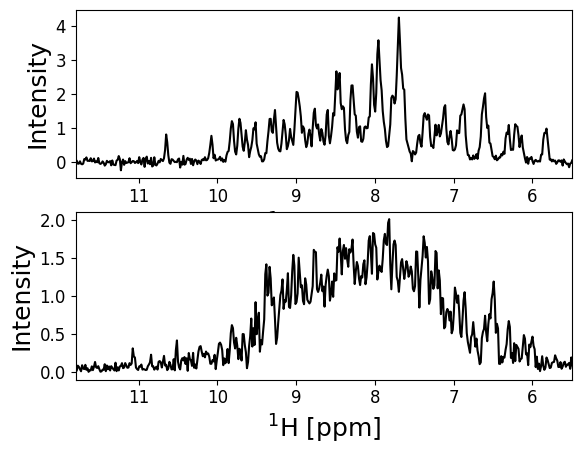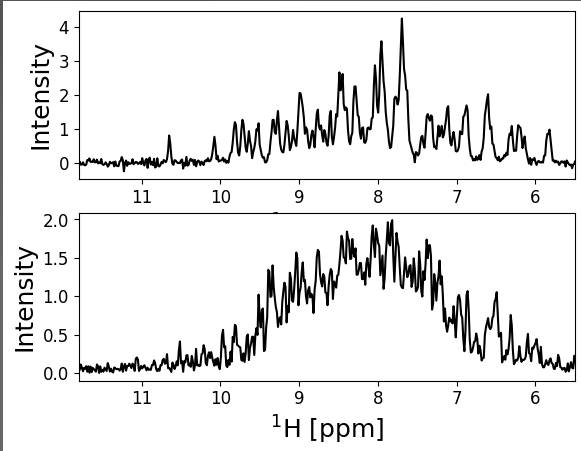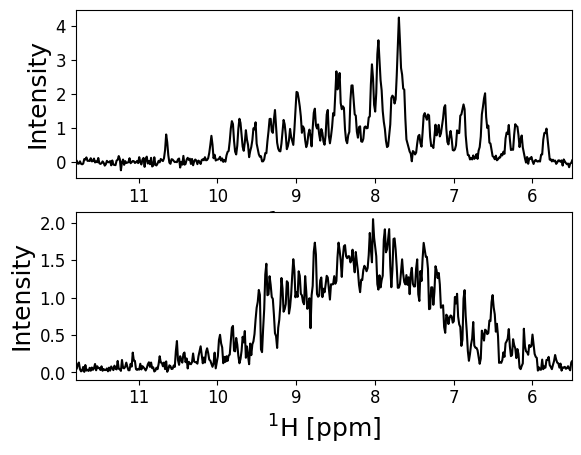
1. 2배 기본
2. 2배 추가
3. 3배 추가
4. 큐빗수 2로 줄이고 파라미터 3배